**1. Introdução**

O objetivo deste trabalho é analisar um problema de ciência de dados com as técnicas de aprendizado de máquina de bagging e pasting. Para isso, será utilizado como exemplo o problema descrito na seção 2.3.3 apresentado em https://github.com/ivanovitchm/EEC1509_Machine_Learning_2019_2/blob/master/Lesson%2308/Lesson_08_Ensemble_Learning_I.ipynb.

A base de dados utilizada consite em um banco de dados sobre a renda de americanos no censo do ano de 1994.

A maior parte do código fonte apresentado a seguir foi originalmente obtido do artigo do link acima. O objetivo deste trabalho é realizar a personalização do pipeline apresentado e seus impactos no desempenho do modelo e principalmente em relação ao overfitting. 

**2. Analisando a base de dados**

O primeiro passo é analisar como a base de dados está estruturada.

In [1]:
# Exibe o início do arquivo.
!head -n 5 income.csv

# Verifica o número de linhas do arquivo.
!wc -l income.csv

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
39, State-gov, 77516, Bachelors, 13, Never-married, Adm-clerical, Not-in-family, White, Male, 2174, 0, 40, United-States, <=50K
50, Self-emp-not-inc, 83311, Bachelors, 13, Married-civ-spouse, Exec-managerial, Husband, White, Male, 0, 0, 13, United-States, <=50K
38, Private, 215646, HS-grad, 9, Divorced, Handlers-cleaners, Not-in-family, White, Male, 0, 0, 40, United-States, <=50K
53, Private, 234721, 11th, 7, Married-civ-spouse, Handlers-cleaners, Husband, Black, Male, 0, 0, 40, United-States, <=50K
32562 income.csv


Como o arquivo CSV está bem estruturado, ele pode ser lido utilizando Pandas.

In [2]:
import pandas as pd

# Carrega a base de dados e exibe a sua estrutura inicial.
income = pd.read_csv('income.csv', sep=',')
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
# Verifica se existe algum valor nulo.
income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    32561 non-null object
high_income       32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Como se vê acima, a base de dados possui 32561 entradas e nenhum valor não nulo. Porém, 9 colunas são categóricas - não numéricas - e precisam ser pré-processadas de maneira diferente.


**3. Pré-processamento da base de dados**

O primeiro passo é converter a coluna alvo (o que nosso modelo pretende prever para categórica, isto é, as faixas de renda do invíduo).

In [4]:
col = pd.Categorical(income.high_income)
income["high_income"] = col.codes
print(col)

[<=50K, <=50K, <=50K, <=50K, <=50K, ..., <=50K, >50K, <=50K, <=50K, >50K]
Length: 32561
Categories (2, object): [<=50K, >50K]


Como se vê acima, só existem duas categorias: menour ou igual a 50k ou maior que 50k USD e estas foram convertidas para 0 ou 1, respectivamente.

As classes abaixo são definidas para tratar as demais colunas (ambas copiadas do artigo original).


In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self.feature_names ]

#converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
  #Class constructor method that takes a boolean as its argument
  def __init__(self, new_features=True):
    self.new_features = new_features

  #Return self nothing else to do here    
  def fit( self, X, y = None ):
    return self 
        
  #Transformer method we wrote for this transformer 
  def transform(self, X , y = None ):
    df = X.copy()
    if self.new_features:
      # Treat ? workclass as unknown
      df['workclass']= df['workclass'].replace('?','Unknown') 
      # Two many category level, convert just US and Non-US
      df.loc[df['native_country']!=' United-States','native_country'] = 'non_usa' 

    # convert columns to categorical
    for name in df.columns.to_list():
      col = pd.Categorical(df[name])
      df[name] = col.codes
    
    #returns numpy array
    return df        

Para validar as classes acima:

In [6]:
model = CategoricalTransformer(new_features=True)
df = model.transform(income.drop(labels=["high_income"],axis=1))
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,22,7,2671,9,12,4,1,1,4,1,25,0,39,0
1,33,6,2926,9,12,2,4,0,4,1,0,0,12,0
2,21,4,14086,11,8,0,6,1,4,1,0,0,39,0
3,36,4,15336,1,6,2,6,0,2,1,0,0,39,0
4,11,4,19355,9,12,2,10,5,2,0,0,0,39,1


In [7]:
model = FeatureSelector(income.select_dtypes("object").columns.to_list())
df = model.transform(income.drop(labels=["high_income"],axis=1))
df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba


Como se vê acima, ambas as classes serviram para pré-processar a base dados, tanto fazendo a conversão de variáveis não numérica para numéricas quanto para fazer a seleção das features com maior relevância.

**Configuração do modelo de aprendizagem de máquina**

Com a base de dados pré-processada, agora podemos criar o modelo de aprendizagem de máquina. Os parâmetros a seguir foram copiados do artigo original para posteriormente fazermos uma comparação na mudança dos hiperparâmetros do modelo.

In [0]:
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

# global varibles
seed = 42
num_folds = 10
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

O passo seguinte é separar o conjunto de teste e treinamento (também seguindo a mesma estrutura do artigo original).

In [0]:
from sklearn.model_selection import train_test_split

# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(income.drop(labels="high_income", axis=1),
                                                    income["high_income"],
                                                    test_size=0.20,
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=income["high_income"])

Com os conjuntos de treinamento e testes construídos, podemos finalmente definir os pipelines que processarão tanto as variáveis categóricas quanto numéricas.

In [0]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler

# Categrical features to pass down the categorical pipeline 
categorical_features = income.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline 
numerical_features = income.select_dtypes("int64").columns.to_list()

# Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline(steps = [('cat_selector', FeatureSelector(categorical_features)),
                                         ('cat_transformer', CategoricalTransformer())
                                         ]
                                )
# Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                       ('std_scaler', MinMaxScaler()) 
                                       ]
                              )

# Combining numerical and categorical piepline into one full big pipeline horizontally 
# using FeatureUnion
full_pipeline_preprocessing = FeatureUnion(transformer_list = [('categorical_pipeline', categorical_pipeline),
                                                               ('numerical_pipeline', numerical_pipeline)
                                                               ]
                                           )

Para validar como os pipelines acima puderam processar o dataframe como um todo, abaixo será exibido o seu formato final, em que todos os valores das features são numéricos e devidamente normalizados para escalas de mesma ordem de grandeza.

In [11]:
new_data = full_pipeline_preprocessing.fit_transform(X_train)
new_data_df = pd.DataFrame(new_data,columns = categorical_features + numerical_features)
new_data_df.head()

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,4.0,9.0,2.0,4.0,0.0,4.0,1.0,0.0,0.205479,0.016928,0.800000,0.000000,0.0,0.448980
1,4.0,12.0,4.0,4.0,1.0,4.0,0.0,0.0,0.356164,0.060896,0.866667,0.000000,0.0,0.448980
2,0.0,11.0,4.0,0.0,1.0,4.0,0.0,0.0,0.041096,0.074679,0.533333,0.000000,0.0,0.275510
3,2.0,15.0,0.0,14.0,4.0,4.0,1.0,0.0,0.315068,0.008474,0.600000,0.068491,0.0,0.397959
4,4.0,9.0,4.0,10.0,3.0,4.0,1.0,0.0,0.095890,0.069037,0.800000,0.000000,0.0,0.397959


**4. Escolha do modelo de aprendizagem de máquina**

In [0]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV

# The full pipeline as a step in another pipeline with an estimator as the final step
pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("clf", RandomForestClassifier())])

# create a dictionary with the hyperparameters
# 12 x num_fold + 120 x num_folds = 1320 models =]
# 50min 
search_space = [
                {"clf": [DecisionTreeClassifier()],
                 "clf__criterion": ["gini", "entropy"],
                 "clf__splitter": ["best", "random"],
                 "clf__random_state": [seed],
                 "fs__score_func": [chi2],
                 "fs__k": [4, 6, 8]},
                {"clf":[RandomForestClassifier()],
                 "clf__n_estimators": [100,200,300,400],
                 "clf__criterion": ["gini","entropy"],
                 "clf__max_leaf_nodes": [4,16,32,64,128],
                 "clf__random_state": [seed],
                 "fs__score_func":[chi2],
                 "fs__k":[4,6,8]}]

# create grid search
kfold = KFold(n_splits=num_folds,random_state=seed)

# return_train_score=True
# official documentation: "computing the scores on the training set can be
# computationally expensive and is not strictly required to
# select the parameters that yield the best generalization performance".
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")


Como o treinamento do modelo acima é bastante custoso, o professor já disponibilizou o arquivo com os valores do treinamento. Logo, ele pode ser ignorado para economizar tempo.

In [0]:
# Realize o treinamento somente se o arquivo com treinamento prévio não for encontrado.
import pickle

try:
  best_model = pickle.load(open('pipe.pkl', 'rb'))
except:
  best_model = grid.fit(X_train, y_train)

Finalmente, exibe o desempenho do modelo treinado:

In [14]:
print("Best: %f using %s" % (best_model.best_score_, best_model.best_params_))

result = pd.DataFrame(best_model.cv_results_)
result.head(10)

Best: 0.902703 using {'clf': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=128,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False), 'clf__criterion': 'entropy', 'clf__max_leaf_nodes': 128, 'clf__n_estimators': 200, 'clf__random_state': 42, 'fs__k': 8, 'fs__score_func': <function chi2 at 0x7faf2197eb70>}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__criterion,param_clf__random_state,param_clf__splitter,param_fs__k,param_fs__score_func,param_clf__max_leaf_nodes,param_clf__n_estimators,params,split0_test_AUC,split1_test_AUC,split2_test_AUC,split3_test_AUC,split4_test_AUC,split5_test_AUC,split6_test_AUC,split7_test_AUC,split8_test_AUC,split9_test_AUC,mean_test_AUC,std_test_AUC,rank_test_AUC,split0_train_AUC,split1_train_AUC,split2_train_AUC,split3_train_AUC,split4_train_AUC,split5_train_AUC,split6_train_AUC,split7_train_AUC,split8_train_AUC,split9_train_AUC,mean_train_AUC,std_train_AUC,split0_test_Accuracy,split1_test_Accuracy,split2_test_Accuracy,split3_test_Accuracy,split4_test_Accuracy,split5_test_Accuracy,split6_test_Accuracy,split7_test_Accuracy,split8_test_Accuracy,split9_test_Accuracy,mean_test_Accuracy,std_test_Accuracy,rank_test_Accuracy,split0_train_Accuracy,split1_train_Accuracy,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.094254,0.004465,0.052384,0.000343,"DecisionTreeClassifier(class_weight=None, crit...",gini,42,best,4,<function chi2 at 0x7faf2197eb70>,NaN,NaN,{'clf': DecisionTreeClassifier(class_weight=No...,0.879737,0.770063,0.890067,0.754662,0.860297,0.894153,0.841077,0.829657,0.823056,0.830986,0.837376,0.044736,115,0.899191,0.898719,0.897951,0.898341,0.842931,0.898022,0.845008,0.846032,0.846578,0.844377,0.871715,0.026747,0.840307,0.785797,0.847601,0.779655,0.812668,0.849136,0.819194,0.810365,0.787634,0.807220,0.813959,0.024112,77,0.848867,0.848569,0.848057,0.848228,0.809410,0.848057,0.808642,0.809623,0.812105,0.808778,0.829034,0.019343
1,0.107457,0.005159,0.054094,0.001872,"DecisionTreeClassifier(class_weight=None, crit...",gini,42,best,6,<function chi2 at 0x7faf2197eb70>,NaN,NaN,{'clf': DecisionTreeClassifier(class_weight=No...,0.882060,0.795158,0.900740,0.787234,0.900339,0.902825,0.785493,0.778393,0.795487,0.767909,0.829567,0.055405,119,0.926336,0.916263,0.915367,0.915165,0.925340,0.915251,0.915892,0.916630,0.927437,0.915181,0.918886,0.004944,0.844914,0.802687,0.852975,0.803071,0.851440,0.858349,0.804990,0.796929,0.797235,0.836406,0.824900,0.024614,60,0.863456,0.861067,0.860939,0.860299,0.863413,0.860257,0.859873,0.861281,0.864699,0.860561,0.861585,0.001572
2,0.140714,0.005217,0.059645,0.010914,"DecisionTreeClassifier(class_weight=None, crit...",gini,42,best,8,<function chi2 at 0x7faf2197eb70>,NaN,NaN,{'clf': DecisionTreeClassifier(class_weight=No...,0.832547,0.754089,0.820625,0.772732,0.824723,0.821800,0.748504,0.744559,0.760581,0.810092,0.789025,0.034058,131,0.980977,0.981498,0.981194,0.981385,0.981547,0.981339,0.981833,0.981429,0.981561,0.981447,0.981421,0.000216,0.834549,0.802303,0.839923,0.806526,0.826104,0.833013,0.802687,0.800000,0.796083,0.826421,0.816761,0.015868,71,0.924711,0.925607,0.924754,0.925394,0.925863,0.925436,0.926332,0.925308,0.926079,0.925653,0.925514,0.000492
3,0.087781,0.011223,0.052276,0.000583,"DecisionTreeClassifier(class_weight=None, crit...",gini,42,random,4,<function chi2 at 0x7faf2197eb70>,NaN,NaN,{'clf': DecisionTreeClassifier(class_weight=No...,0.883280,0.786899,0.890114,0.780701,0.856721,0.887777,0.839006,0.827547,0.820158,0.830930,0.840314,0.037303,113,0.899191,0.898719,0.897951,0.898341,0.842931,0.898022,0.845008,0.846032,0.846578,0.844377,0.871715,0.026747,0.842610,0.794626,0.848752,0.790019,0.811516,0.846833,0.818426,0.809597,0.786866,0.807220,0.815648,0.022034,72,0.848867,0.848569,0.848057,0.848228,0.809410,0.848057,0.808642,0.809623,0.812105,0.808778,0.829034,0.019343
4,0.094351,0.004778,0.055624,0.004322,"DecisionTreeClassifier(class_weight=None, crit...",gini,42,random,6,<function chi2 at 0x7faf2197eb70>,NaN,NaN,{'clf': DecisionTreeClassifier(class_weight=No...,0.881333,0.794939,0.893739,0.804949,0.899048,0.898314,0.770400,0.775795,0.834018,0.764106,0.831667,0.05367

In [15]:
result[result.rank_test_AUC == 1][['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
125,0.921701,0.000456,0.902703,0.014056


Verirficando o desempenho do modelo em relação a overfitting (com relação a AUC e acurácia).

In [16]:
# Training score much higher than test score.
# The standard deviation of the test score is large.
result_auc = result[['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]
result_auc

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
0,0.871715,0.026747,0.837376,0.044736
1,0.918886,0.004944,0.829567,0.055405
2,0.981421,0.000216,0.789025,0.034058
3,0.871715,0.026747,0.840314,0.037303
4,0.918886,0.004944,0.831667,0.053675
5,0.981421,0.000216,0.788347,0.028335
6,0.871715,0.026747,0.836769,0.044576
7,0.918886,0.004944,0.828649,0.056380
8,0.981421,0.000216,0.789393,0.034622
9,0.871715,0.026747,0.838221,0.039218


In [17]:
result_acc = result[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
0,0.829034,0.019343,0.813959,0.024112
1,0.861585,0.001572,0.824900,0.024614
2,0.925514,0.000492,0.816761,0.015868
3,0.829034,0.019343,0.815648,0.022034
4,0.861585,0.001572,0.827165,0.023130
5,0.925514,0.000492,0.814304,0.013337
6,0.829034,0.019343,0.813690,0.024254
7,0.861585,0.001572,0.825015,0.024786
8,0.925514,0.000492,0.817222,0.015864
9,0.829034,0.019343,0.814573,0.022890


In [39]:
result[result.rank_test_Accuracy == 1][['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
68,0.870363,0.000617,0.848818,0.016177


Testando o modelo acima com o conjunto treinamento.

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

# final model
predict = best_model.predict(X_test)
print(roc_auc_score(y_test, predict))
print(accuracy_score(y_test, predict))
print(confusion_matrix(y_test,predict))
print(classification_report(y_test,predict))

0.7695127267287096
0.8662674650698603
[[4728  217]
 [ 654  914]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4945
           1       0.81      0.58      0.68      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.77      0.80      6513
weighted avg       0.86      0.87      0.86      6513



**Analisando a feature importance do modelo**

Com base nos resultados acima, após a otimização do modelo (usando o GridSearchCV), nota-se que a RandomForest apresentou o melhor resultado quando comparada a uma árvore de decisão simples (foi o modelo vencedor pela GridSearchCV). De fato este resultado era esperado.

Sabe-se também que uma RandomForest consiste na técnica de bagging utilizando-se várias ávores de decisão, logo a combinação de vários resultados dessas ávores geralmente produzem um resultado final melhor que o de apenas uma.

Uma análise inicial a ser feita é a de feature importante. Primeiramente será mostrado o resultado gerado pela própria RandomForest.

In [36]:
%matplotlib inline
#!pip3 install eli5
#!pip3 install skater

import eli5 

fs = best_model.best_estimator_.steps[1][1] # SelectKBest
support = fs.get_support(indices=False)
selected_columns = X_train.columns[support]

# # Exibe a feature importance da RandomForest.
for name, value in zip(selected_columns.to_list(), best_model.best_params_['clf'].feature_importances_):
  print(name, value)

# Utilizando a biblioteca ELI5, exibe a feature importance da RandomForest.
eli5.show_weights(best_model.best_params_['clf'], show_feature_values=True, feature_names=selected_columns.to_list())

workclass 0.09276902300197479
fnlwgt 0.1916404622960708
education 0.0691661254504158
education_num 0.2087449363666952
occupation 0.0286553232838529
race 0.12782775787455983
capital_loss 0.21721125249814452
hours_per_week 0.06398511922828627


Weight,Feature
0.2172 ± 0.0849,capital_loss
0.2087 ± 0.3344,education_num
0.1916 ± 0.3092,fnlwgt
0.1278 ± 0.1533,race
0.0928 ± 0.0773,workclass
0.0692 ± 0.0602,education
0.0640 ± 0.0464,hours_per_week
0.0287 ± 0.0750,occupation


Para contrapor o resultado de feature importance da RandomForest, abaixo ela será calculada utilizando a biblioteca Skater.

2019-10-15 05:09:11,712 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[8/8] features ████████████████████ Time elapsed: 3 seconds

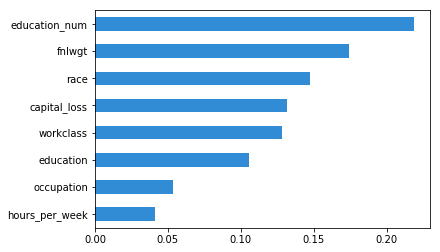

In [37]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import matplotlib.pyplot as plt

# Utilizando a biblioteca Skater, exibe a feature importance.
X_temp1 = best_model.best_estimator_.steps[0][1].transform(X_train)
X_temp2 = best_model.best_estimator_.steps[1][1].transform(X_temp1)

interpreter = Interpretation(training_data=X_temp2, training_labels=y_train, 
                               feature_names=selected_columns.to_list())

im_model = InMemoryModel(best_model.best_params_['clf'].predict_proba, examples=X_temp2, target_names=['$50K or less', 'More than $50K'])

plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True)

É interessante notar que no resultado acima, as features possem pesos diferentes daqueles gerados pela RandomForest. Isso pode sugerir que o modelo pode não estar otimizado para seu melhor desempenho, visto que a RandomForest está tratando as features com pesos diferentes daqueles sugeridos pela outra biblioteca. Com isso, a seguir novos modelos e hiperparâmetros serão avaliados.

**Personalizando hipermarâmetros em busca de uma melhoria no modelo**

A seguir, serão construídos modelos utilizando-se a técnica de Bagging e Pasting utilizando árvores de decisão, o que é similar à RandomForest.

> Indented block



In [0]:
from sklearn.ensemble import BaggingClassifier


# instantiate a bagging object (model,size,samples,bootstrap,rnd)
bag_clf = BaggingClassifier(DecisionTreeClassifier(random_state=seed, splitter='random'), 
                            n_estimators=200,
                            bootstrap=True, 
                            oob_score=True,
                            random_state=seed)

pas_clf = BaggingClassifier(DecisionTreeClassifier(random_state=seed, splitter='random'), 
                            n_estimators=200,
                            bootstrap=False, 
                            oob_score=False,
                            random_state=seed)

# The full pipeline as a step in another pipeline with an estimator as the final step
pipe_bag = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("clf", bag_clf)])

pipe_pas = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("clf", pas_clf)])

search_space =  {
                  "fs__score_func": [chi2],
                  "fs__k": [4, 6, 8]
                 }
              

grid_bag = GridSearchCV(estimator=pipe_bag, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")


grid_pas = GridSearchCV(estimator=pipe_bag, 
                    param_grid=search_space,
                    cv=kfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")

# Treine os modelos novamente caso não encontre-os.
try:
  model_bag = pickle.load(open('pipe-bag.pkl', 'rb'))
except:
  model_bag = grid_bag.fit(X_train, y_train)
  with open('pipe-bag.pkl', 'wb') as file:
    pickle.dump(model_bag, file)

try:
  model_pas = pickle.load(open('pipe-pas.pkl', 'rb'))
except:
  model_pas = grid_pas.fit(X_train, y_train)
  with open('pipe-pas.pkl', 'wb') as file:
    pickle.dump(model_pas, file)



Para avaliar ambos os modelos acima, será utilizada a mesma metodologia usada no caso da RandomForest apresentada inicialmente.

Primeiramente para a técnica de bagging.

In [23]:
# Para a técnica de bagging.
result_bag = pd.DataFrame(model_bag.cv_results_)
result_bag[result_bag.rank_test_AUC == 1][['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
2,0.979087,0.000222,0.877549,0.011415


In [24]:
result_acc = result_bag[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
0,0.829034,0.019343,0.814074,0.023963
1,0.861585,0.001572,0.826282,0.024127
2,0.925514,0.000492,0.836571,0.011741


In [40]:
result_bag[result_bag.rank_test_Accuracy == 1][['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
2,0.925514,0.000492,0.836571,0.011741


In [25]:
# Exibe resultado do OOB
print(model_bag.best_estimator_[2].oob_score_)

0.8430589680589681


No resultado do OOB, nota-se que a acurácia esperada no conjunto de teste será em torno de 84%. De fato, isto pode ser percebido abaixo.

In [26]:
s

ROC AUC =  0.7710282495202327
Accuracy =  0.8427759864885613
[[4497  448]
 [ 576  992]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4945
           1       0.69      0.63      0.66      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.77      0.78      6513
weighted avg       0.84      0.84      0.84      6513



No resultado acima, entretanto, nota-se que o overfitting itensificou-se já que a diferença entre tanto a acurácia e da ROC AUC aumentaram entre o conjunto treinamento e teste. 

Agora será analisado o modelo utilizando pasting.

In [27]:
# Para a técnica de pasting.
result_pas = pd.DataFrame(model_pas.cv_results_)
result_pas[result_pas.rank_test_AUC == 1][['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
2,0.979087,0.000222,0.877549,0.011415


In [28]:
result_acc = result_pas[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
0,0.829034,0.019343,0.814074,0.023963
1,0.861585,0.001572,0.826282,0.024127
2,0.925514,0.000492,0.836571,0.011741


In [41]:
result_pas[result_pas.rank_test_Accuracy == 1][['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
2,0.925514,0.000492,0.836571,0.011741


In [29]:
predict_pas = model_pas.predict(X_test)
print("ROC AUC = ", roc_auc_score(y_test, predict_pas))
print("Accuracy = ", accuracy_score(y_test, predict_pas))
print(confusion_matrix(y_test, predict_pas))
print(classification_report(y_test, predict_pas))

ROC AUC =  0.7710282495202327
Accuracy =  0.8427759864885613
[[4497  448]
 [ 576  992]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4945
           1       0.69      0.63      0.66      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.77      0.78      6513
weighted avg       0.84      0.84      0.84      6513



Novamente, o resultado do pasting foi muito similar ao do bagging, com uma piora no overfitting em relação à RandomForest original. Portanto, a tentativa final a seguir será no sentido de tentar melhorar a RandomForest original através de modificações no seu pipeline.

No pipeline original, será alterado o tipo KFold para StratifiedKFold, com o objetivo de melhorar a validação cruzada no exemplo original.

In [0]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=num_folds, random_state=seed)

pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                         ("fs", SelectKBest()),
                         ("clf", RandomForestClassifier())])

# Seach space simplificado para ser mais rápido.
search_space = [
                {"clf":[RandomForestClassifier()],
                 "clf__n_estimators": [200,],
                 "clf__criterion": ["entropy"],
                 "clf__max_leaf_nodes": [128],
                 "clf__max_depth": [8, 32],
                 "clf__bootstrap": [False],
                 "clf__random_state": [seed],
                 "fs__score_func":[chi2],
                 "fs__k":[8]}]

# return_train_score=True
# official documentation: "computing the scores on the training set can be
# computationally expensive and is not strictly required to
# select the parameters that yield the best generalization performance".
grid = GridSearchCV(estimator=pipe, 
                    param_grid=search_space,
                    cv=skfold,
                    scoring=scoring,
                    return_train_score=True,
                    n_jobs=-1,
                    refit="AUC")

try:
  final_model = pickle.load(open('pipe-final.pkl', 'rb'))
except:
  final_model = grid.fit(X_train, y_train)
  with open('pipe-final.pkl', 'wb') as file:
    pickle.dump(final_model, file)


Analisando os mesmos resultados dos modelos anteriores.

In [121]:
result_final = pd.DataFrame(final_model.cv_results_)
result_final[result_final.rank_test_AUC == 1][['mean_train_AUC', 'std_train_AUC','mean_test_AUC', 'std_test_AUC']]

,mean_train_AUC,std_train_AUC,mean_test_AUC,std_test_AUC
1,0.921257,0.000457,0.90218,0.013995


In [122]:
result_acc = result_final[['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]
result_acc

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
0,0.854316,0.000765,0.837607,0.015154
1,0.868107,0.000902,0.848050,0.017370


In [123]:
result_final[result_final.rank_test_Accuracy == 1][['mean_train_Accuracy', 'std_train_Accuracy','mean_test_Accuracy', 'std_test_Accuracy']]

,mean_train_Accuracy,std_train_Accuracy,mean_test_Accuracy,std_test_Accuracy
1,0.868107,0.000902,0.84805,0.01737


In [124]:
predict_final = final_model.predict(X_test)
print("ROC AUC = ", roc_auc_score(y_test, predict_final))
print("Accuracy = ", accuracy_score(y_test, predict_final))
print(confusion_matrix(y_test, predict_final))
print(classification_report(y_test, predict_final))

ROC AUC =  0.7703837879944698
Accuracy =  0.8662674650698603
[[4724  221]
 [ 650  918]]
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4945
           1       0.81      0.59      0.68      1568

    accuracy                           0.87      6513
   macro avg       0.84      0.77      0.80      6513
weighted avg       0.86      0.87      0.86      6513



Como se vê acima, o resultado da acurácia no conjunto de teste ficou muito mais próximo que em todos os modelos analisados anteriormente. Logo, o StratifiedKFold ajudou a reduzir o overfitting e melhorou o resultado da RandomForest.

Por fim, o melhor modelo obtido é mostrado a seguir.

In [125]:
final_model.best_estimator_

Pipeline(memory=None,
         steps=[('full_pipeline',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('categorical_pipeline',
                                                 Pipeline(memory=None,
                                                          steps=[('cat_selector',
                                                                  FeatureSelector(feature_names=['workclass',
                                                                                                 'education',
                                                                                                 'marital_status',
                                                                                                 'occupation',
                                                                                                 'relationship',
                                                                                                 'race',
           